In [9]:

'''#### EXERCÍCIO 1 #### '''

# ----> Importando as bibliotecas <----#
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import CubicSpline
from scipy.misc import derivative

In [10]:

#----> TABELA <----#
H = np.array((0, 68, 135, 203, 271, 338, 406, 474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000))
B = np.array((0, 0.733, 1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703, 1.724, 1.731, 1.738, 1.761, 1.77, 1.8, 1.816))

In [11]:

#----> CONSTANTES <----#
numPontos = 100

N = 1000           #Nº de espiras
g = 2e-3           #Comprimento do entreferro
d = 4e-2           #Profundidade do ferro
l = 4e-2           #Largura do ferro
Lc = 70e-2         #Comprimento do ferro
u0 = 4*np.pi*1e-7  #Permeabilidade do vácuo


In [12]:

def gerarFuncoesForcas(correntes:list)->list:

  '''
  Gera um dicionário de funções das forcas Reais, Lineares e Ideais para cada corrente do parâmetro correntes
  '''

  funcoesForcas_reais = []
  funcoesForcas_lineares = []
  funcoesForcas_ideais = []

  #Repetição para cada I
  for Ibob in correntes:   #Define o Ibob da vez

    curvaHxB_real = CubicSpline(B, H, bc_type='natural')              #Curva real HxB
    curvaHxB_linear = CubicSpline(B[0:2], H[0:2], bc_type='natural')  #Aproximação linear da curva HxB

    Bint = np.linspace(0, np.max(B), numPontos) #Intervalo de variação de B


    #Definindo os vetores H em relação a variação de B
    H_real = curvaHxB_real(Bint)
    H_linear = curvaHxB_linear(Bint)


    Ac = d*l #Área do núcleo

    lambdaInt = N*Ac*Bint                      #Intervalo de variação do fluxo concatenado
    xInt = np.linspace(0, d, numPontos+1)[:-1] #Intervalo de variação de x (remove o último elemento)
    Iint = np.linspace(0, Ibob, numPontos)     #Intervalo de variação da corrente


    #Definição dos vetores vazios da coenergia
    wc_real = []
    wc_linear = []
    wc_ideal = []


    #Repetição para cada posição x
    for x in xInt:

      A0 = (d-x)*l   #Área do entreferro

      I_real = (H_real*Lc + 2*g*(Bint*Ac)/(u0*A0))/N      #Corrente a partir da Lei de Ampere
      I_linear = (H_linear*Lc + 2*g*(Bint*Ac)/(u0*A0))/N  #Corrente para o caso linear
      I_ideal = (2*g*(Bint*Ac)/(u0*A0))/N                 #Corrente para o caso Ideal (Hc = 0)



      curvaLambdaXI_real = CubicSpline(I_real, lambdaInt, bc_type='natural')     #Curva fluxo concatenado por corrente real
      curvaLambdaXI_linear = CubicSpline(I_linear, lambdaInt, bc_type='natural') #Curva fluxo concatenado por corrente linear
      curvaLambdaXI_ideal = CubicSpline(I_ideal, lambdaInt, bc_type='natural')   #Curva fluxo concatenado por corrente ideal


      #Definindo o vetor fluxo concatenado no intervalo de variação de I (0 à Ibob)
      lambda_real = curvaLambdaXI_real(Iint)
      lambda_linear = curvaLambdaXI_linear(Iint)
      lambda_ideal = curvaLambdaXI_ideal(Iint)


      #Definindo o vetor coenergia integrando o fluxo no intervalo de variação de I (0 à Ibob)
      wc_real.append(sp.integrate.trapezoid(lambda_real, Iint))
      wc_linear.append(sp.integrate.trapezoid(lambda_linear, Iint))
      wc_ideal.append(sp.integrate.trapezoid(lambda_ideal, Iint))



    #Transformando os vetores para np.array's
    wc_real = np.array(wc_real)
    wc_linear = np.array(wc_linear)
    wc_ideal = np.array(wc_ideal)


    #Curvas coenergia em função da variação de x
    curvaWCxX_real = CubicSpline(xInt, wc_real, bc_type='natural')
    curvaWCxX_linear = CubicSpline(xInt, wc_linear, bc_type='natural')
    curvaWCxX_ideal = CubicSpline(xInt, wc_ideal, bc_type='natural')


    #Determinando a força magnética pela derivada da coenergia em relação a x
    Forca_real = derivative(curvaWCxX_real, xInt, dx=np.max(xInt)/numPontos)
    Forca_linear = derivative(curvaWCxX_linear, xInt, dx=np.max(xInt)/numPontos)
    Forca_ideal = derivative(curvaWCxX_ideal, xInt, dx=np.max(xInt)/numPontos)


    #Determinando as funções de força pela posição
    curvaFxX_real = CubicSpline(xInt, Forca_real, bc_type='natural')
    curvaFxX_linear = CubicSpline(xInt, Forca_linear, bc_type='natural')
    curvaFxX_ideal = CubicSpline(xInt, Forca_ideal, bc_type='natural')


    #Adiciona as funções F x X da vez no vetor de forças
    funcoesForcas_reais.append(curvaFxX_real)
    funcoesForcas_lineares.append(curvaFxX_linear)
    funcoesForcas_ideais.append(curvaFxX_ideal)

  return {'Reais': np.array(funcoesForcas_reais), 'Lineares': np.array(funcoesForcas_lineares), 'Ideais': np.array(funcoesForcas_ideais)}


<ipython-input-12-ec67919fa2ee>:80: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_real = derivative(curvaWCxX_real, xInt, dx=np.max(xInt)/numPontos)
<ipython-input-12-ec67919fa2ee>:81: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_linear = derivative(curvaWCxX_linear, xInt, dx=np.max(xInt)/numPontos)
<ipython-input-12-ec67919fa2ee>:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forc

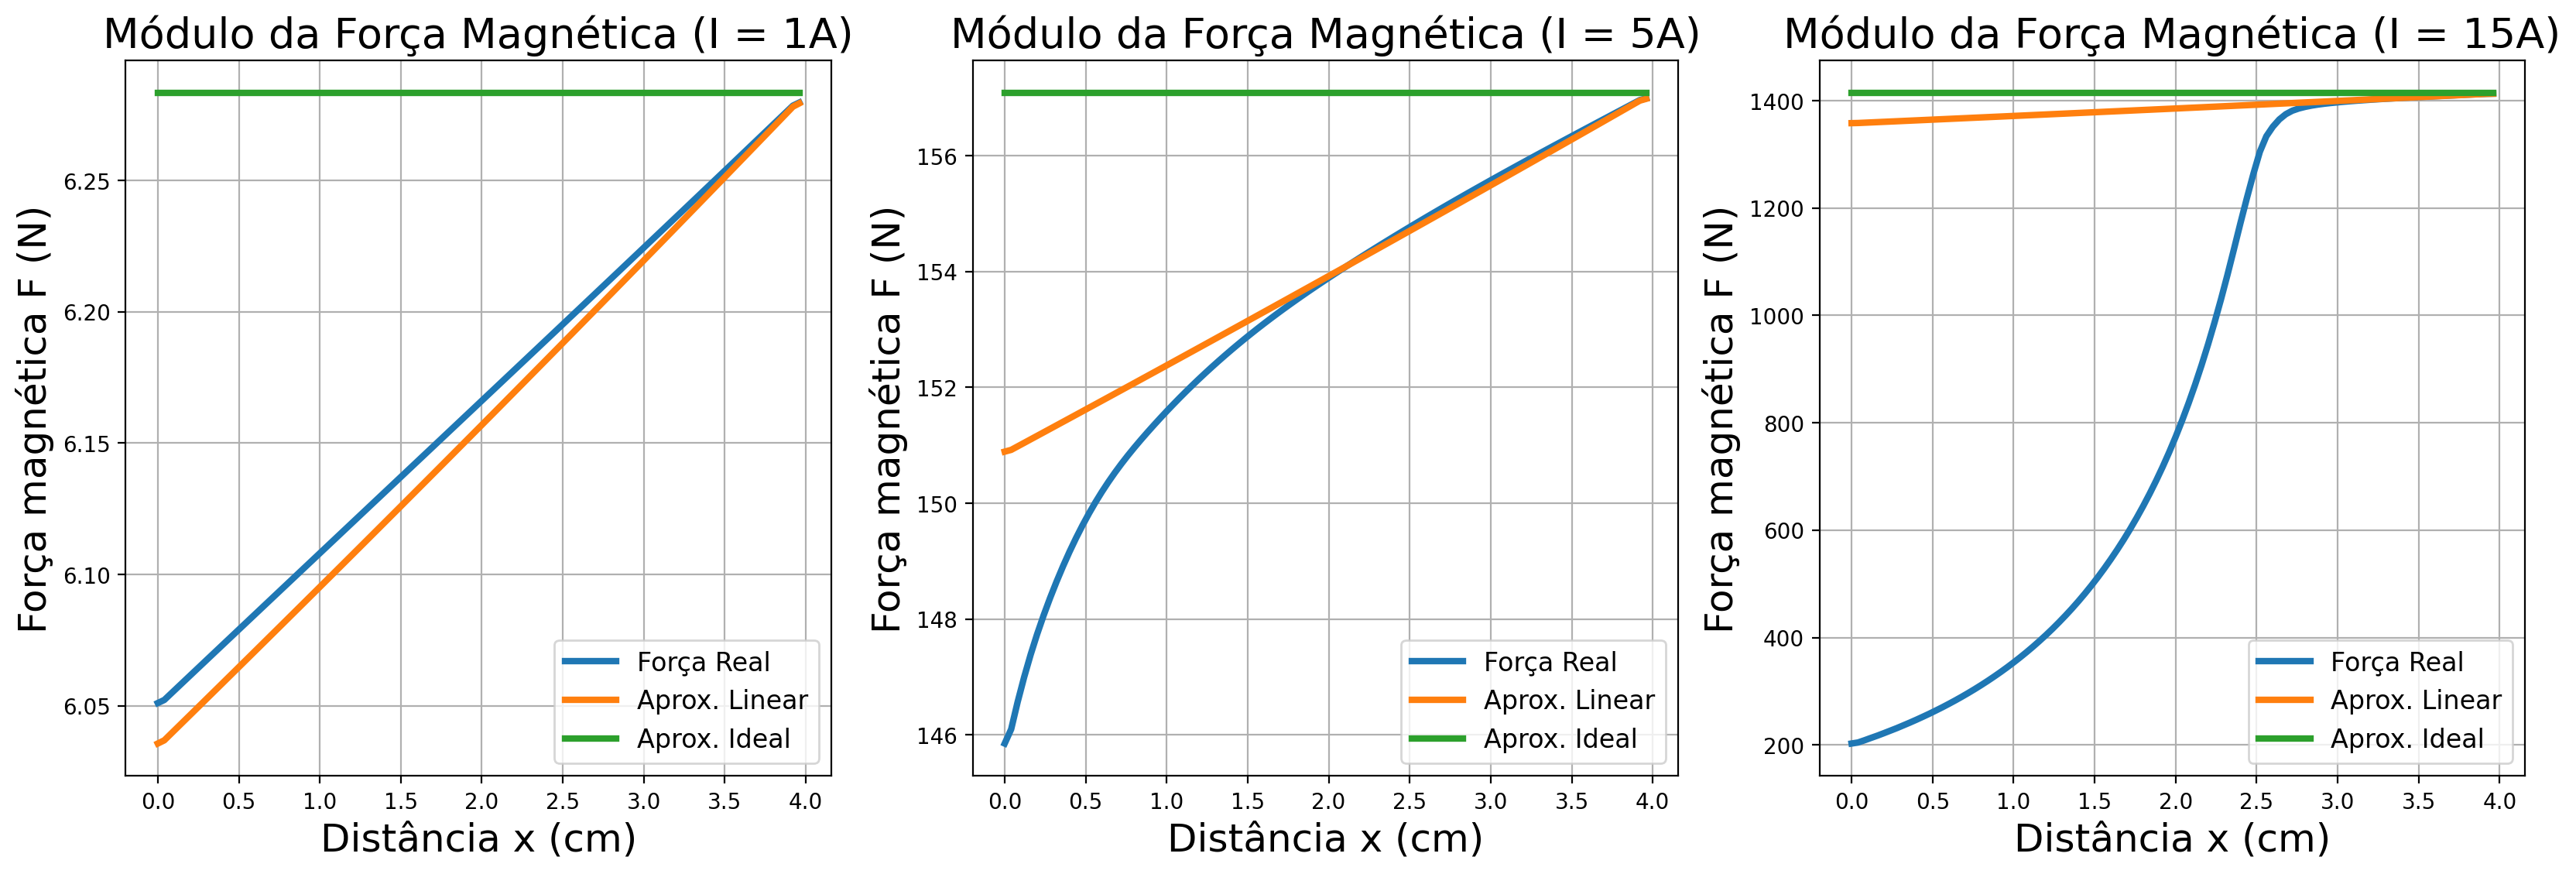

In [13]:

'''
#------------------------------------#
#-------------> PARTE 1 <------------#
#-> Força Magnética em função de x <-#
#------------------------------------#
'''

Ibob = (1, 5, 15)     #Vetor de correntes na bobina

#Gera as funçoes forças por deslocamento com base nas corrente fornecidas
funcoesForcas = gerarFuncoesForcas(Ibob)


#Define os vetores das funções força por deslocamento para cada tipo
funcoesForcas_reais = funcoesForcas['Reais']
funcoesForcas_lineares = funcoesForcas['Lineares']
funcoesForcas_ideais = funcoesForcas['Ideais']


#intervalo de variação de x
xInt = np.linspace(0, d, numPontos+1)[:-1] #remove o último elemento


#Gráficos das forças
plt.figure(figsize=(20,6), dpi=200)

for i in range(len(Ibob)):

  #Gera um vetor de força em função da posição para cada tipo
  Forcas_real = funcoesForcas_reais[i](xInt)
  Forcas_linear = funcoesForcas_lineares[i](xInt)
  Forcas_ideal = funcoesForcas_ideais[i](xInt)

  #Plota os gráficos
  plt.subplot(1,3,i+1)

  plt.plot(xInt*100, np.abs(Forcas_real), label='Força Real', linewidth=3)
  plt.plot(xInt*100, np.abs(Forcas_linear), label='Aprox. Linear',  linewidth=3)
  plt.plot(xInt*100, np.abs(Forcas_ideal), label='Aprox. Ideal',  linewidth=3)

  plt.title(f'Módulo da Força Magnética (I = {Ibob[i]}A)',fontsize=19.5)
  plt.xlabel('Distância x (cm)', fontsize=18)
  plt.ylabel('Força magnética F (N)', fontsize=18)
  plt.legend(fontsize=12)
  plt.grid()


In [14]:

'''
#---------------------#
#-----> PARTE 2 <-----#
#-> Corrente máxima <-#
#---------------------#
'''

#Curva do campo magnético pela densidade de fluxo magnético
curvaHxB = CubicSpline(B, H, bc_type='natural')

#Determinado a densidade de fluxo máxima de acordo com a tabela
Bc_max = np.max(B)

#Determiando o campo magnético máximo através da curva interpolada
Hc_max = curvaHxB(Bc_max)

#Determinando a corrente máxima através da lei de Ampere

Ac = l*d #Área do núcleo
A0 = Ac # Área do entreferro quando x = 0

Imax = (Hc_max*Lc + 2*g*Bc_max*Ac/(u0*A0))/N

print(f'A corrente máxima confiável é:{Imax} A')


A corrente máxima confiável é:23.280507533097634 A


<ipython-input-12-ec67919fa2ee>:80: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_real = derivative(curvaWCxX_real, xInt, dx=np.max(xInt)/numPontos)
<ipython-input-12-ec67919fa2ee>:81: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_linear = derivative(curvaWCxX_linear, xInt, dx=np.max(xInt)/numPontos)
<ipython-input-12-ec67919fa2ee>:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forc

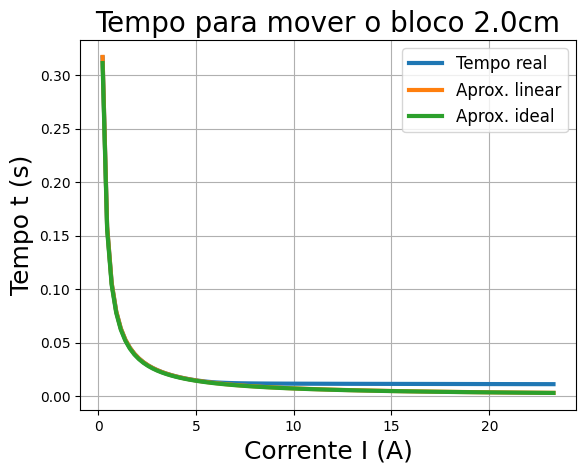

In [15]:

'''
#-------------------------------------#
#--------------> PARTE 3 <------------#
#-> Tempo necessário em função de I <-#
#-------------------------------------#
'''

M = 1 #Massa do bloco (Kg)

Ibob = np.linspace(0, Imax, numPontos+1)[1:]   #Vetor de correntes na bobina (remove o primero elemento)

#Gera as funções forças por deslocamento com base nas correntes fornecidas
funcoesForcas = gerarFuncoesForcas(Ibob)


#Define os vetores das funções força por deslocamento para cada tipo
funcoesForcas_reais = funcoesForcas['Reais']
funcoesForcas_lineares = funcoesForcas['Lineares']
funcoesForcas_ideais = funcoesForcas['Ideais']


xInt = np.linspace(0, d, numPontos+1)[:-1] #intervalo de variação de x (remove o último elemento)


#Vetores para armazenar o tempo
tempo_real = []
tempo_linear = []
tempo_ideal = []


#Repetição para cada corrente
for i in range(len(Ibob)):

  #Derterminando o vetor do trabalho mecânico
  trab_real = []
  trab_linear = []
  trab_ideal = []


  #Determinando valores de trabalho em função de x [integra de 0 a x para cada valor de x variando de 0 a d]
  for j in range(numPontos):
    trab_real.append(-sp.integrate.trapezoid(funcoesForcas_reais[i](xInt[0:j+1]), xInt[0:j+1]))
    trab_linear.append(-sp.integrate.trapezoid(funcoesForcas_lineares[i](xInt[0:j+1]), xInt[0:j+1]))
    trab_ideal.append(-sp.integrate.trapezoid(funcoesForcas_ideais[i](xInt[0:j+1]), xInt[0:j+1]))


  #Vetor trabalho em função de x
  trab_real = np.array(trab_real)
  trab_linear = np.array(trab_linear)
  trab_ideal = np.array(trab_ideal)


  #Determinando a velocidade em função de x igualando o trabalho mecânico à energia cinética do bloco
  vel_real = np.sqrt((2*trab_real)/M)
  vel_linear = np.sqrt((2*trab_linear)/M)
  vel_ideal = np.sqrt((2*trab_ideal)/M)


  #Definindo a curva V x X
  curvaVxX_real = CubicSpline(xInt, vel_real, bc_type='natural')
  curvaVxX_linear = CubicSpline(xInt, vel_linear, bc_type='natural')
  curvaVxX_ideal = CubicSpline(xInt, vel_ideal, bc_type='natural')


  #Limites de integração de x
  xLimInt = np.linspace(0, d/2, numPontos+1)[1:]


  #Definindo o vetor velocidade com x variando de 0 à d/2
  vel_real = curvaVxX_real(xLimInt)
  vel_linear = curvaVxX_linear(xLimInt)
  vel_ideal = curvaVxX_ideal(xLimInt)


  #Determina o tempo e armazena no vetor
  tempo_real.append(sp.integrate.trapezoid(1/vel_real, xLimInt))
  tempo_linear.append(sp.integrate.trapezoid(1/vel_linear, xLimInt))
  tempo_ideal.append(sp.integrate.trapezoid(1/vel_ideal, xLimInt))


#Definindo os vetores tempo
tempo_real = np.array(tempo_real)
tempo_linear = np.array(tempo_linear)
tempo_ideal = np.array(tempo_ideal)


#Define a curva TxI
curvaTxI_real = CubicSpline(Ibob, tempo_real)
curvaTxI_linear = CubicSpline(Ibob, tempo_linear)
curvaTxI_ideal = CubicSpline(Ibob, tempo_ideal)

T_real = curvaTxI_real(Ibob)
T_linear = curvaTxI_linear(Ibob)
T_ideal = curvaTxI_ideal(Ibob)


#Gráficos do tempo pela corrente
plt.figure()

plt.plot(Ibob, T_real, label='Tempo real', linewidth=3)
plt.plot(Ibob, T_linear, label='Aprox. linear', linewidth=3)
plt.plot(Ibob, T_ideal, label='Aprox. ideal', linewidth=3)
plt.legend(fontsize=12)
plt.title(f'Tempo para mover o bloco {d/2*100}cm',fontsize=20)
plt.xlabel('Corrente I (A)',fontsize=18)
plt.ylabel('Tempo t (s)',fontsize=18)
plt.grid()
